# Project: Anomalous Lines in APOGEE Spectra (ALIAS)

## About this tutorial:

This tutorial explores the Sloan Digital Sky Survey's APOGEE data in the near-infrared (H-band): https://www.sdss.org/dr17/irspec/.

Refer to different types of APOGEE spectral data files [here](https://www.sdss.org/dr17/irspec/spectro_data/#ScienceArchiveServer(SAS):
- The pseudo-continuum normalized, combined spectrum, with best matching synthetic ASPCAP spectrum is recorded as one file per object in the **aspcapStar** file.
- The combined, RV-corrected spectra are recorded as one file per object in the **apStar** (observed by northern spectrograph) or **asStar** (observed by southern spectrograph) files. In the **allStar** (or equivalent) summary file, the filename for the combined spectrum is contained in the `FILE` tag. Thus, the user can build the URL from information contained in the **allStar** file.
- The individual visit spectra are recorded as one file per visit in the **apVisit** or **asVisit** files. This information can be acquired from the **allVisit** summary file, or in the `VISITS` tag of the **allStar** file.

The dataset that we particularly explore is the **allStar** summary file `allStar-dr17-synspec_rev1.fits` that can be downloaded from [here](https://www.sdss.org/dr17/irspec/spectro_data/#SummaryCatalogs). `allStar` contains all final data product and summary information for every observed star in the data release. The information includes radial velocities, stellar parameters, and abundances for each star, obtained from the combined spectra. This is the [data model](https://data.sdss.org/datamodel/files/APOGEE_ASPCAP/APRED_VERS/ASPCAP_VERS/allStar.html) that was used to construct the `allStar` catalog. From this summary data, we will pull the spectra themselves for individual stars.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.table import Table
from astropy.io import fits

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
file = 'allStar-dr17-synspec_rev1.fits'

In [4]:
tbl = Table.read(file)

In [6]:
tbl

FILE,APOGEE_ID,TARGET_ID,APSTAR_ID,ASPCAP_ID,TELESCOPE,LOCATION_ID,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,H_ERR,K,K_ERR,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,TARG_PMRA,TARG_PMDEC,TARG_PM_SRC,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,APOGEE2_TARGET4,TARGFLAGS,SURVEY,PROGRAMNAME,NVISITS,SNR,SNREV,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CHI2,RV_CCFWHM,RV_AUTOFWHM,RV_FLAG,N_COMPONENTS,MEANFIB,SIGFIB,MIN_H,MAX_H,MIN_JK,MAX_JK,GAIAEDR3_SOURCE_ID,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PHOT_G_MEAN_MAG,GAIAEDR3_PHOT_BP_MEAN_MAG,GAIAEDR3_PHOT_RP_MEAN_MAG,GAIAEDR3_DR2_RADIAL_VELOCITY,GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR,GAIAEDR3_R_MED_GEO,GAIAEDR3_R_LO_GEO,GAIAEDR3_R_HI_GEO,GAIAEDR3_R_MED_PHOTOGEO,GAIAEDR3_R_LO_PHOTOGEO,GAIAEDR3_R_HI_PHOTOGEO,ASPCAP_GRID,"FPARAM_GRID [21,9]",CHI2_GRID [21],FPARAM [9],"FPARAM_COV [9,9]",ASPCAP_CHI2,PARAM [9],"PARAM_COV [9,9]",PARAMFLAG [9],ASPCAPFLAG,ASPCAPFLAGS,FRAC_BADPIX,FRAC_LOWSNR,FRAC_SIGSKY,FELEM [27],FELEM_ERR [27],X_H [27],X_H_ERR [27],X_M [27],X_M_ERR [27],ELEM_CHI2 [27],ELEMFRAC [27],ELEMFLAG [27],EXTRATARG,MEMBERFLAG,MEMBER,X_H_SPEC [27],X_M_SPEC [27],TEFF,TEFF_ERR,LOGG,LOGG_ERR,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,VMICRO,VMACRO,VSINI,TEFF_SPEC,LOGG_SPEC,C_FE,C_FE_SPEC,C_FE_ERR,C_FE_FLAG,CI_FE,CI_FE_SPEC,CI_FE_ERR,CI_FE_FLAG,N_FE,N_FE_SPEC,N_FE_ERR,N_FE_FLAG,O_FE,O_FE_SPEC,O_FE_ERR,O_FE_FLAG,NA_FE,NA_FE_SPEC,NA_FE_ERR,NA_FE_FLAG,MG_FE,MG_FE_SPEC,MG_FE_ERR,MG_FE_FLAG,AL_FE,AL_FE_SPEC,AL_FE_ERR,AL_FE_FLAG,SI_FE,SI_FE_SPEC,SI_FE_ERR,SI_FE_FLAG,P_FE,P_FE_SPEC,P_FE_ERR,P_FE_FLAG,S_FE,S_FE_SPEC,S_FE_ERR,S_FE_FLAG,K_FE,K_FE_SPEC,K_FE_ERR,K_FE_FLAG,CA_FE,CA_FE_SPEC,CA_FE_ERR,CA_FE_FLAG,TI_FE,TI_FE_SPEC,TI_FE_ERR,TI_FE_FLAG,TIII_FE,TIII_FE_SPEC,TIII_FE_ERR,TIII_FE_FLAG,V_FE,V_FE_SPEC,V_FE_ERR,V_FE_FLAG,CR_FE,CR_FE_SPEC,CR_FE_ERR,CR_FE_FLAG,MN_FE,MN_FE_SPEC,MN_FE_ERR,MN_FE_FLAG,FE_H,FE_H_SPEC,FE_H_ERR,FE_H_FLAG,CO_FE,CO_FE_SPEC,CO_FE_ERR,CO_FE_FLAG,NI_FE,NI_FE_SPEC,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,YB_FE,YB_FE_SPEC,YB_FE_ERR,YB_FE_FLAG,VISIT_PK [100]
bytes64,bytes30,bytes58,bytes71,bytes77,bytes6,int32,bytes20,bytes30,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,bytes16,float32,bytes32,float32,float32,int32,int32,int32,int32,int32,int32,bytes132,bytes32,bytes32,int32,float32,float32,int64,bytes132,int64,bytes132,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,int64,int64,bytes256,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int64,int32,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float3

In [120]:
len(tbl) # this many stars, some stars are visited multiple times

733901

In the 2D histogram below, the observations contained in the `allStar` file are grouped into 100 bins in each dimension (RA and Dec). Redder colors indicate higher density of number of observations at that location in the sky.

BUT why do the observation density make this shape?

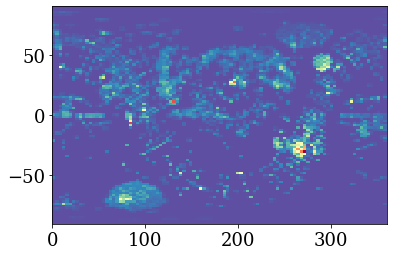

In [27]:
hist_2d_map = plt.hist2d(tbl['RA'], tbl['DEC'],range=[[0,360],[-90,90]],bins=[100, 100], cmap=plt.cm.Spectral_r)

In [40]:
max([max(counts) for counts in hist_2d_map[0]])
# the maximum count, but where is it located???

3001.0

The histogram below shows the counts of stars in 100 bins that correlate with the distances of the stars to the Earth. It's interesting that there's a plunge in the number of surveyed stars located at approximately $10^3$ pc away.

Text(0, 0.5, 'Number of Stars')

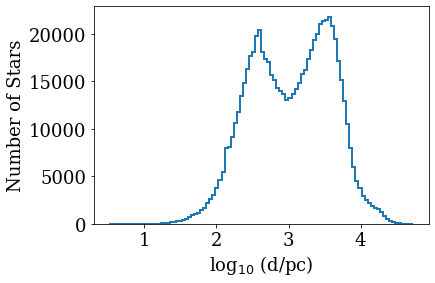

In [94]:
_ = plt.hist(np.log10(tbl['GAIAEDR3_R_LO_PHOTOGEO']),bins=100, lw=2, histtype='step')
plt.xlabel(r'log$_{10}$ (d/pc)')
plt.ylabel('Number of Stars')

# lw indicates the size of the steps being drawn

# HR Diagrams

In [120]:
allStar = fits.open("allStar-dr17-synspec_rev1.fits")
data = allStar[1].data

starbad = 2**23 #bit flag for bad stars 
gd = np.bitwise_and(data["ASPCAPFLAG"], starbad) == 0 
teff_logg_check = np.logical_and(data["TEFF"] > 0, data["LOGG"] > -10) # this checks for -9999 values
teff_logg_feh_check = np.logical_and(data["FE_H"]> -6, teff_logg_check)

indices = np.where(np.logical_and(gd, teff_logg_feh_check)) 
good = data[indices] # this only the good data now
Teff_vals = good["TEFF"]
logg_vals = good["LOGG"] # surface gravity
FeH_vals = good["FE_H"]

In [110]:
len(indices[0]) # the good data contain this many spectrum

647042

Text(0, 0.5, 'surface gravity')

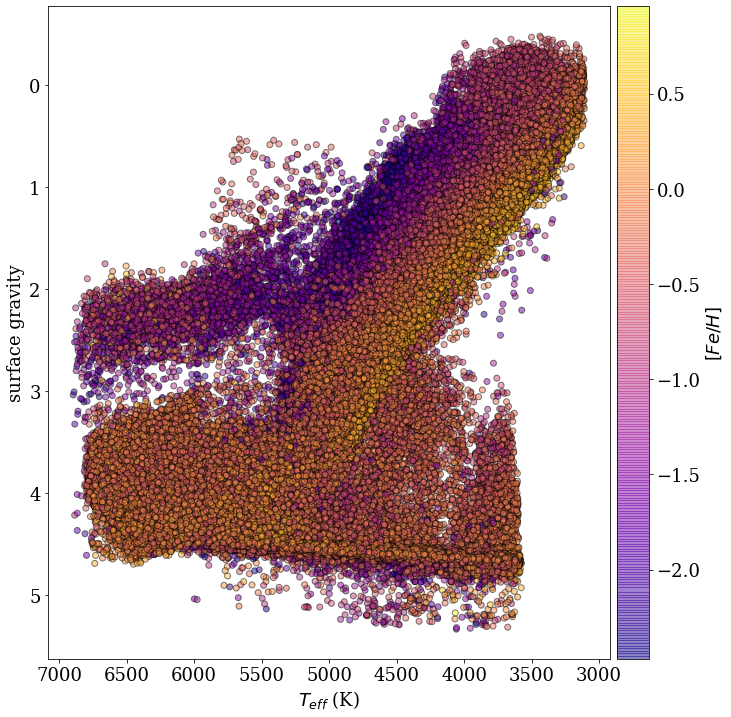

In [96]:
# plotting the HR Diagram

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

image = ax.scatter(Teff_vals,logg_vals, c=FeH_vals ,edgecolor='k',cmap="plasma",alpha=0.5)
bar = fig.colorbar(image,orientation="vertical",pad=0.01)
bar.set_label('$[Fe/H]$')
ax.invert_xaxis()
ax.invert_yaxis()

plt.xlabel('$T_{eff}$ (K)')
plt.ylabel('surface gravity')
#plt.savefig('hrdiagram1.png',dpi=150,bbox_inches='tight')

Text(0, 0.5, '$M_G$')

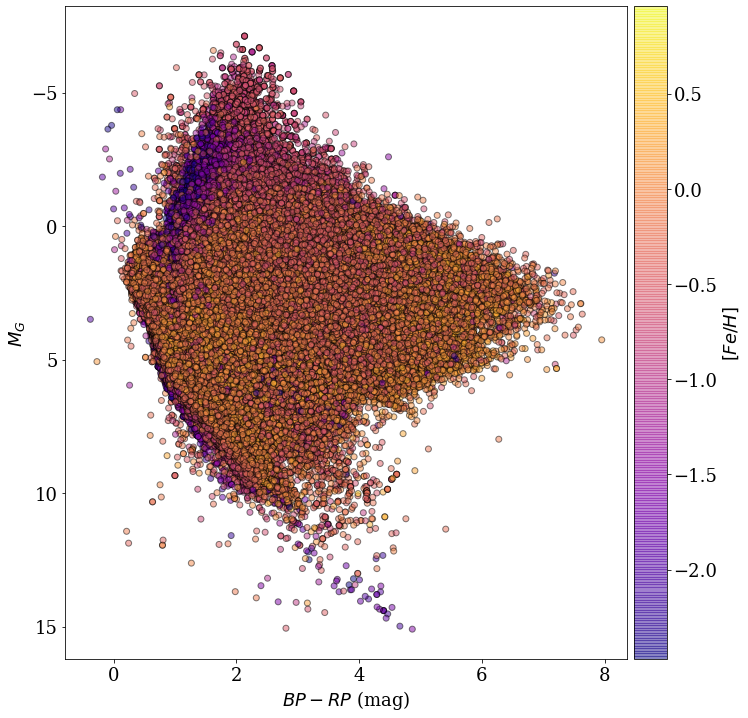

In [111]:
# plotting the CMD

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

image = ax.scatter(good['GAIAEDR3_PHOT_BP_MEAN_MAG'] - good['GAIAEDR3_PHOT_RP_MEAN_MAG'], 
                   good['GAIAEDR3_PHOT_G_MEAN_MAG'] - 5.* np.log10(good['GAIAEDR3_R_MED_PHOTOGEO'])+5,
                   c=FeH_vals ,edgecolor='k',cmap="plasma",alpha=0.5)

bar = fig.colorbar(image,orientation="vertical",pad=0.01)
bar.set_label('$[Fe/H]$')
ax.invert_yaxis()

plt.xlabel('$BP - RP$ (mag)')
plt.ylabel('$M_G$')

# Abundance Plot
Source: https://github.com/sdss/apogee2_tutorials/blob/main/examples/APOGEE_Abundance_Plot.ipynb

In [35]:
# Select Stars with Reliable Measurements

starbad = 2**23
gd1 = np.bitwise_and(data["ASPCAPFLAG"], starbad) == 0

# Select Samples toward the Inner and Outer Galaxy using (l,b)

gd = np.logical_and(data["LOGG"] < 4, gd1 )

# Select the Inner Galaxy using Galactic Latitude and Longitude
i_cut = np.logical_or(np.abs(data["GLON"])>=350, data["GLON"]<=10)
l_bsmall_check = np.logical_and(np.abs(data["GLAT"])<5, i_cut)

# Select the Outer Galaxy using Galactic Latitude and Longitude
o_cut = np.logical_and(np.abs(data["GLON"])>90, data["GLON"]<270)
l_bbig_check = np.logical_and(np.abs(data["GLAT"])<10, o_cut)

# Apply criteria for the abundances
abun_good = np.logical_and(data["FE_H_ERR"]<0.05, data["MG_FE_ERR"]<0.05)

# Combine the samples defined above
l_bsmall_Feh_check = np.logical_and(l_bsmall_check, abun_good)
l_bbig_Feh_check = np.logical_and(l_bbig_check, abun_good)
ind_1 = np.where(np.logical_and(gd, l_bsmall_Feh_check))
ind_2 = np.where(np.logical_and(gd, l_bbig_Feh_check))

# Make separate arrays 
good1 = data[ind_1]
good2 = data[ind_2]

# Create the Plotting Arrays
alpha1 = good1["MG_FE"]
FeH1= good1["FE_H"]

alpha2= good2["MG_FE"]
FeH2 = good2["FE_H"]

Text(0.5, 1.0, 'Outer Galaxy')

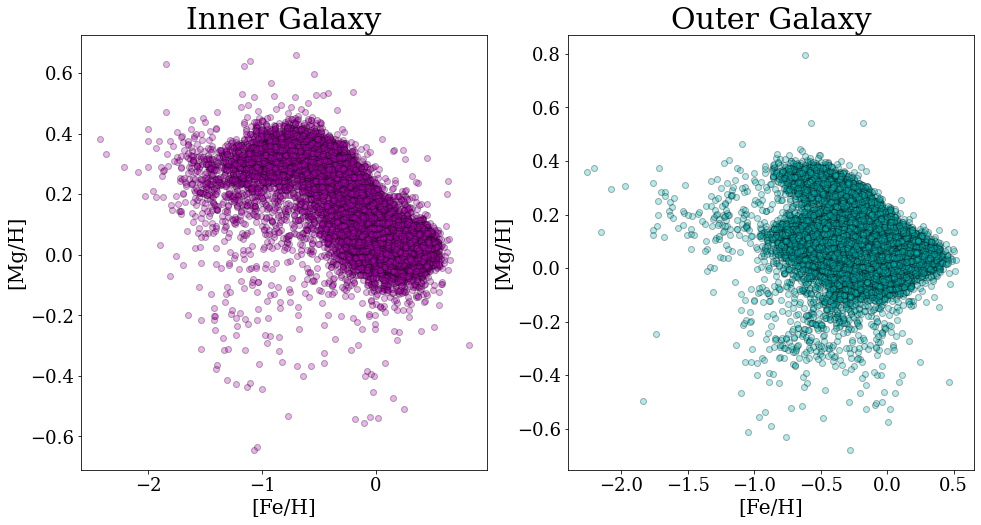

In [36]:
# Plotting

fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot(121)
image1 = ax1.scatter(FeH1, alpha1, c="m" ,edgecolor='k',alpha=0.3)
ax1.set_xlabel("[Fe/H]", size=20)
ax1.set_ylabel("[Mg/H]", size=20)
ax1.set_title("Inner Galaxy", size=30)

ax2 = fig.add_subplot(122)
image2 = ax2.scatter(FeH2, alpha2, c="c", edgecolor='k', alpha=0.3)
ax2.set_xlabel("[Fe/H]", size=20)
ax2.set_ylabel("[Mg/H]", size=20)
ax2.set_title("Outer Galaxy", size=30)
#plt.savefig("alpha_fe.png")

# Inspecting the stars within 100 pc

In [51]:
# select stars within 100pc (aka GCNS)

n100pc = tbl['GAIAEDR3_R_LO_PHOTOGEO'] <= 100
print('There are this many stars within 100 pc:', sum(n100pc))

There are this many stars within 100 pc: 18184


The histogram below shows the counts of stars within 100 pc grouped within 60 bins of BP - RP magnitudes. The red line indicates the color of the Sun.

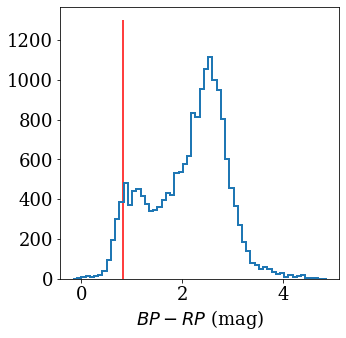

In [52]:
plt.figure(figsize=(5,5))

_ = plt.hist(tbl['GAIAEDR3_PHOT_BP_MEAN_MAG'][n100pc] - tbl['GAIAEDR3_PHOT_RP_MEAN_MAG'][n100pc], 
             bins=60, histtype='step', lw=2)
plt.xlabel('$BP - RP$ (mag)')
# approx color of the Sun, https://arxiv.org/abs/1806.01953
plt.vlines(0.82, 0, 1300, color='r')

Below is a color-magnitude diagram of the stars within 100 pc. The red line highlights a group of Sun-like stars with an absolute G magnitude of approx 4.67 and BP - RP of approx 0.82 (according to https://arxiv.org/pdf/1806.01953.pdf).

Text(0, 0.5, '$M_G$')

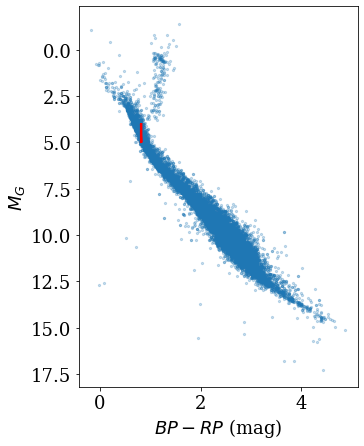

In [99]:
# make CMD

plt.figure(figsize=(5,7))
plt.scatter(tbl['GAIAEDR3_PHOT_BP_MEAN_MAG'][n100pc] - tbl['GAIAEDR3_PHOT_RP_MEAN_MAG'][n100pc], 
            tbl['GAIAEDR3_PHOT_G_MEAN_MAG'][n100pc] - 5.* np.log10(tbl['GAIAEDR3_R_MED_PHOTOGEO'][n100pc])+5, 
            s=5, alpha=0.25, label='d<100pc, N='+str(sum(n100pc)))
plt.plot([0.82+0.01, 0.82+0.01, 0.82-0.01, 0.82-0.01], [4,5,4,5], c='r')
plt.gca().invert_yaxis()
# plt.legend(fontsize=12)
plt.xlabel('$BP - RP$ (mag)')
plt.ylabel('$M_G$')
#plt.savefig('cmd1.png',dpi=150,bbox_inches='tight')

# Inspecting solar-like stars within 300 pc

Stars within 300 pc with BP - RP around 0.82 +/- 0.01, and $M_G$ between 5 and 4.

What's the difference between `GAIAEDR3_R_MED_PHOTOGEO` and `GAIAEDR3_R_HI_PHOTOGEO`?

In [57]:
n300pc = ((tbl['GAIAEDR3_R_HI_PHOTOGEO'] <= 300) & 
         (((tbl['GAIAEDR3_R_HI_PHOTOGEO'] - tbl['GAIAEDR3_R_MED_PHOTOGEO'])/tbl['GAIAEDR3_R_HI_PHOTOGEO']) < 0.01) &
         (tbl['GAIAEDR3_PHOT_BP_MEAN_MAG'] - tbl['GAIAEDR3_PHOT_RP_MEAN_MAG'] < (0.82+0.01)) & 
         (tbl['GAIAEDR3_PHOT_BP_MEAN_MAG'] - tbl['GAIAEDR3_PHOT_RP_MEAN_MAG'] > (0.82-0.01)) & 
         ((tbl['GAIAEDR3_PHOT_G_MEAN_MAG'] - 5.* np.log10(tbl['GAIAEDR3_R_MED_PHOTOGEO'])+5) < 5) &
         ((tbl['GAIAEDR3_PHOT_G_MEAN_MAG'] - 5.* np.log10(tbl['GAIAEDR3_R_MED_PHOTOGEO'])+5) > 4)
        )

print('This many stars within 300 pc have solar-like properties:', sum(n300pc))
print('This many stars within 300 pc with solar-like properties have an absolute G magnitude > 4.4 mag:', sum(tbl['LOGG'][n300pc] > 4.4))

This many stars within 300 pc have solar-like properties: 1730
This many stars within 300 pc with solar-like properties have an absolute G magnitude > 4.4 mag: 907


Text(0, 0.5, 'log g (surface gravity)')

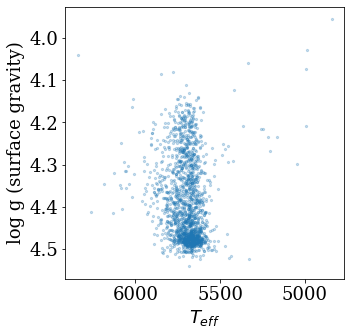

In [93]:
# an HR diagram of the stars in n300pc

plt.figure(figsize=(5,5))
plt.scatter(tbl['TEFF'][n300pc], 
            tbl['LOGG'][n300pc],
            s=5, alpha=0.25)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
# plt.xlim(8000,2000)
plt.xlabel('$T_{eff}$')
plt.ylabel('log g (surface gravity)')
#plt.savefig('hrd2.png',dpi=150,bbox_inches='tight')

Text(0, 0.5, '$M_G$')

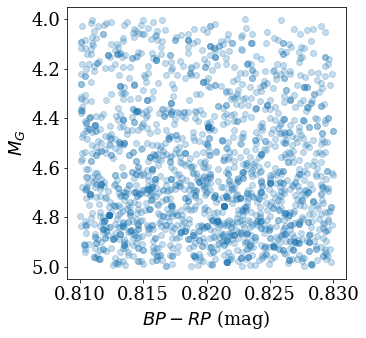

In [70]:
# a CMD of the stars in n300pc

plt.figure(figsize=(5,5))
plt.scatter(tbl['GAIAEDR3_PHOT_BP_MEAN_MAG'][n300pc] - tbl['GAIAEDR3_PHOT_RP_MEAN_MAG'][n300pc], 
            tbl['GAIAEDR3_PHOT_G_MEAN_MAG'][n300pc] - 5.* np.log10(tbl['GAIAEDR3_R_MED_PHOTOGEO'][n300pc])+5, 
            alpha=0.25, label='d<100pc, N='+str(sum(n300pc)))
# plt.vlines(0.82, 16,-1.5, color='r', alpha=0.5)
plt.gca().invert_yaxis()
# plt.legend(fontsize=12)
plt.xlabel('$BP - RP$ (mag)')
plt.ylabel('$M_G$')
# plt.ylim(6.5,2.5)

Text(0, 0.5, 'Number of Stars')

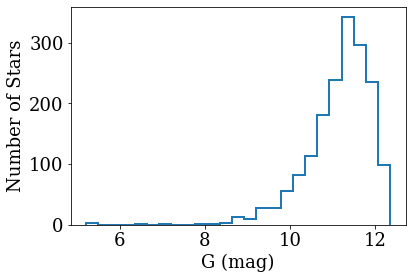

In [71]:
# histogram of the stars in n300pc grouped into bins of G mag

_ = plt.hist(tbl['GAIAEDR3_PHOT_G_MEAN_MAG'][n300pc],bins=25, histtype='step', lw=2)
plt.xlabel('G (mag)')
plt.ylabel('Number of Stars')
#plt.savefig('Gmag.png',dpi=150,bbox_inches='tight')

Text(0, 0.5, 'Number of Stars')

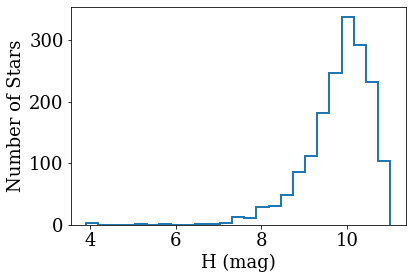

In [72]:
# histogram of the stars in n300pc grouped into bins of H mag

_ = plt.hist(tbl['H'][n300pc],bins=25, histtype='step', lw=2)
plt.xlabel('H (mag)')
plt.ylabel('Number of Stars')
#plt.savefig('Hmag.png',dpi=150,bbox_inches='tight')

Text(0, 0.5, 'Number of Stars')

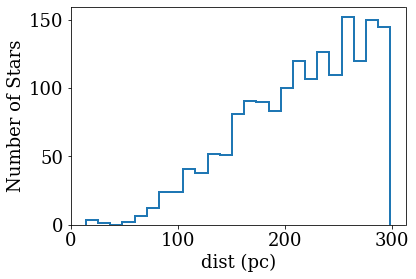

In [73]:
# histogram of the stars in n300pc grouped into bins of distances in pc

_ = plt.hist(tbl['GAIAEDR3_R_MED_PHOTOGEO'][n300pc],bins=25, histtype='step', lw=2)
plt.xlabel('dist (pc)')
plt.ylabel('Number of Stars')
#plt.savefig('dist.png',dpi=150,bbox_inches='tight')

Text(0, 0.5, 'Number of Stars')

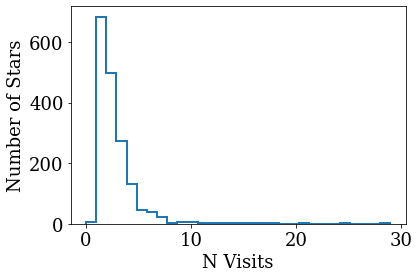

In [78]:
# histogram of the stars in n300pc grouped into bins of number of visits

_ = plt.hist(tbl['NVISITS'][n300pc],bins=30, histtype='step', lw=2)
plt.xlabel('N Visits')
plt.ylabel('Number of Stars')
#plt.savefig('Nvisits.png',dpi=150,bbox_inches='tight')

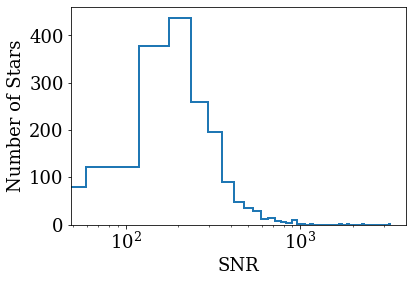

In [87]:
# histogram of the stars in n300pc grouped into bins of signal-to-noise ratios

_ = plt.hist(tbl['SNR'][n300pc],bins=55, histtype='step', lw=2)
plt.xlabel('SNR')
plt.ylabel('Number of Stars')
plt.xscale('log')
#plt.savefig('SNR.png',dpi=150,bbox_inches='tight')

In [89]:
# these are the files to pull for the stars in n300pc

tbl['FILE'][n300pc]

apStar-dr17-2M00030035+1554160.fits
apStar-dr17-2M00061847+1539108.fits
apStar-dr17-2M00091408+1445260.fits
apStar-dr17-2M00115214+8520020.fits
asStar-dr17-2M00124050-1948017.fits
apStar-dr17-2M00125570-1441121.fits
apStar-dr17-2M00164036+1612307.fits
apStar-dr17-2M00203029-0030022.fits
asStar-dr17-2M00241591-7717498.fits
apStar-dr17-2M00252721+1347329.fits
apStar-dr17-2M00275854+0002391.fits


# Inspecting individual spectra

## Construct URLs for data

https://www.sdss.org/dr17/irspec/spectro_data/#ScienceArchiveServer(SAS)

In [91]:
# so we can construct URLs for data: https://www.sdss.org/dr17/irspec/spectro_data/#ScienceArchiveServer(SAS)

TELESCOPE = tbl['TELESCOPE'][n300pc]
FIELD = tbl['FIELD'][n300pc]
FILE = tbl['FILE'][n300pc]

u1 = 'https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars/'

URL = np.array([], dtype=str)
for k in range(sum(n300pc)):
    URL = np.append(URL, u1 + TELESCOPE[k] + '/' + FIELD[k] + '/' + FILE[k])

In [23]:
print('curl -O '+URL[0])

curl -O https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars/apo25m/107-46_MGA/apStar-dr17-2M00030035+1554160.fits


## Inspecting the downloaded individual visit spectra

Refer to the data model for individual spectra [here](https://data.sdss.org/datamodel/files/APOGEE_REDUX/APRED_VERS/stars/TELESCOPE/FIELD/apStar.html#hdu1).

Combined and individual spectra for star, at apStar sampling. Each spectrum has 8575 columns with the spectra, and 2+NVISITS rows. The first two rows are both combined spectra, with different weighting: the first row uses pixel-based weighting where each pixel is weighted by its $(S/N)^2$, while the second row uses a more "global" weighting where each visit spectrum is weighted by its $(S/N)^2$. The two schemes give similar results in most cases, but both are saved. If NVISITS=1, there will only be one row.

Refer to how spectra are reduced [here](https://www.sdss.org/dr12/irspec/apred/) and combined [here](https://www.sdss.org/dr12/irspec/spectral_combination/).

To reconstruct the rest wavelength frame:
- CRVAL1: Start log10(wavelength) in subsequent HDUs
- CDELT1: Dispersion in log10(wavelength) in subsequent HD

In [24]:
hdul = fits.open('apStar-dr17-2M00030035+1554160.fits')
hdul.info()

Filename: apStar-dr17-2M00030035+1554160.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     110   ()      
  1                1 ImageHDU        12   (8575, 4)   float64   
  2                1 ImageHDU        12   (8575, 4)   float64   
  3                1 ImageHDU        12   (8575, 4)   int64   
  4                1 ImageHDU        12   (8575, 4)   float64   
  5                1 ImageHDU        12   (8575, 4)   float64   
  6                1 ImageHDU        12   (8575, 4)   float64   
  7                1 ImageHDU        12   (8575, 4)   float64   
  8                1 ImageHDU         5   ()      
  9                1 BinTableHDU     58   2R x 23C   [72A, D, D, D, D, D, D, D, D, D, D, D, D, D, 765D, 765D, 765D, D, D, D, D, D, 765D]   
 10                1 BinTableHDU     58   1R x 23C   [72A, D, D, D, D, D, D, D, D, D, D, D, D, D, 243D, 243D, 243D, D, D, D, D, D, 243D]   


In [25]:
Table.read(hdul)

# there are 2 visits for this star

filename,jd,snr,vhelio,vrel,vrelerr,teff,tefferr,logg,loggerr,feh,feherr,chisq,bc,x_ccf [765],ccf [765],ccferr [765],xcorr_vrel,xcorr_vrelerr,xcorr_vhelio,ccpfwhm,autofwhm,autoccf [765]
str72,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
apVisit-dr17-12700-59074-289.fits,2459074.94867,38.3683,-21.41839514602738,-41.73366270889359,0.06170941461455686,6018.152620983399,13.872804034001,4.625348836329984,0.012721053700140733,-0.20431472376331283,0.007080864325644301,1.0626368714977397,20.31526756286621,-977.0551169859796 .. 1023.2365418790163,0.0115603554681173 .. 0.010735622560502575,0.003946010404148189 .. 0.00429576689755921,-41.73366270889359,0.038555931150352385,-21.41839514602738,24.77839082370855,22.582218146610426,0.01079114170934774 .. -0.0011084064463405922
apVisit-dr17-12700-59077-289.fits,2459077.90881,63.9336,-21.158836682232717,-40.58204301157842,0.03783946889211021,6018.152620983399,13.872804034001,4.625348836329984,0.012721053700140733,-0.20431472376331283,0.007080864325644301,1.257849651285581,19.423206329345703,-979.4486052624131 .. 1020.9158296973078,0.010334868559352953 .. 0.01282152196247889,0.002749134807811226 .. 0.0030033369171704213,-40.58204301157842,0.05426777725535732,-21.158836682232717,24.933104124281016,22.583102692332332,0.005789881387506711 .. 0.0


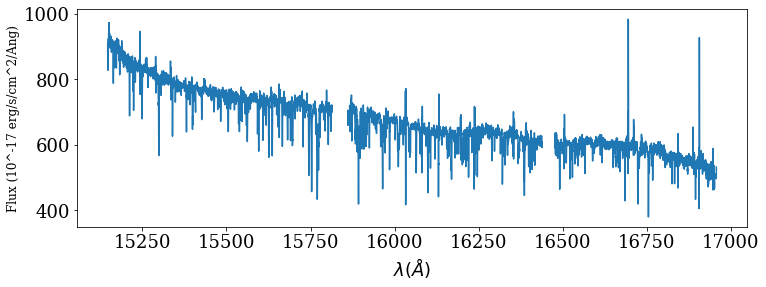

In [26]:
# spectra are in the 1st extension
sp = hdul[1].data

# reconstruct the wavelength axis from the header - NOTE: doesn't work for apVisit files!
wave = 10**(hdul[1].header['CRVAL1'] + (hdul[1].header['CDELT1'] * np.arange(sp.shape[1])))

plt.figure(figsize=(12,4))

# combined spectra are in the first column
plt.plot(wave, sp[0])

plt.xlabel('$\lambda (\AA)$')
plt.ylabel(hdul[1].header['BUNIT'],fontsize=12)
#plt.savefig("spectrum.png")

(15600.0, 15800.0)

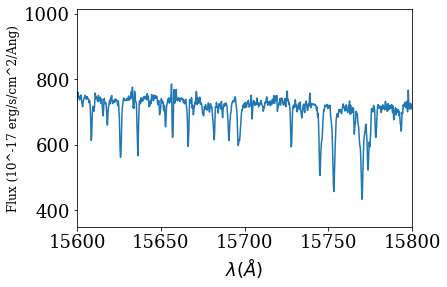

In [30]:
plt.plot(wave, sp[0])

plt.xlabel('$\lambda (\AA)$')
plt.ylabel(hdul[1].header['BUNIT'],fontsize=12)
plt.xlim(15600,15800)

The code above and below explore the same thing– the individual spectrum of the star `2M00030035+1554160`– in 2 slightly different ways.

Text(0, 0.5, 'flux')

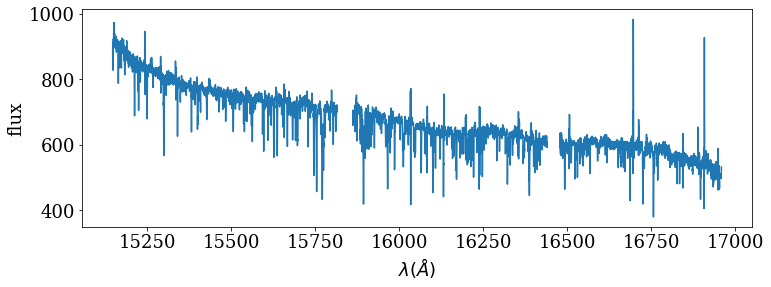

In [121]:
from astropy.io import fits, ascii

### Read in file for magnetic star; get flux and rest frame wavelengths

spec_path='apStar-dr17-2M00030035+1554160.fits'
star='2M00030035+1554160' # just for reference

# spectra are in the 1st extension
#hdul = fits.open('apStar-dr17-2M00030035+1554160.fits')
#sp = hdul[1].data

f=fits.getdata(spec_path) # if ext is not specified and primary header contains no data, getdata attempts to retrieve data from first extension HDU
hdr=fits.getheader(spec_path)
nf=len(f[0,:]) # : means getting all the data in that dimension
crval=np.double(hdr['CRVAL1'])
cdelt=np.double(hdr['CDELT1'])
vhelio = hdr['VHELIO'] # each star has its own value of heliocentric velocity
w=np.empty(nf)

# shift the observed wavelength to the rest frame
for k in range(nf): w[k]=crval+(cdelt*k) # could have been done with numpy.arange to speed up
w=10.0**w
c=299792.458e0
w=w-((vhelio/c)*w) 

# heliocentric velocity (roughly constant) divided by speed of light --> Doppler shift
# vhelio can be calculated by the position of the telescope and the coordinates of the star
# also need to account for systemic velocity of the star if comparing multiple stars together
# if comparing multiple spectra of a star, then the systemic velocity of the star is a constant offset

plt.figure(figsize=(12,4))
plt.plot(w, f[0,:])
plt.xlabel('$\lambda (\AA)$')
plt.ylabel('flux')
#plt.savefig("spectrum.png")

Text(0, 0.5, 'flux')

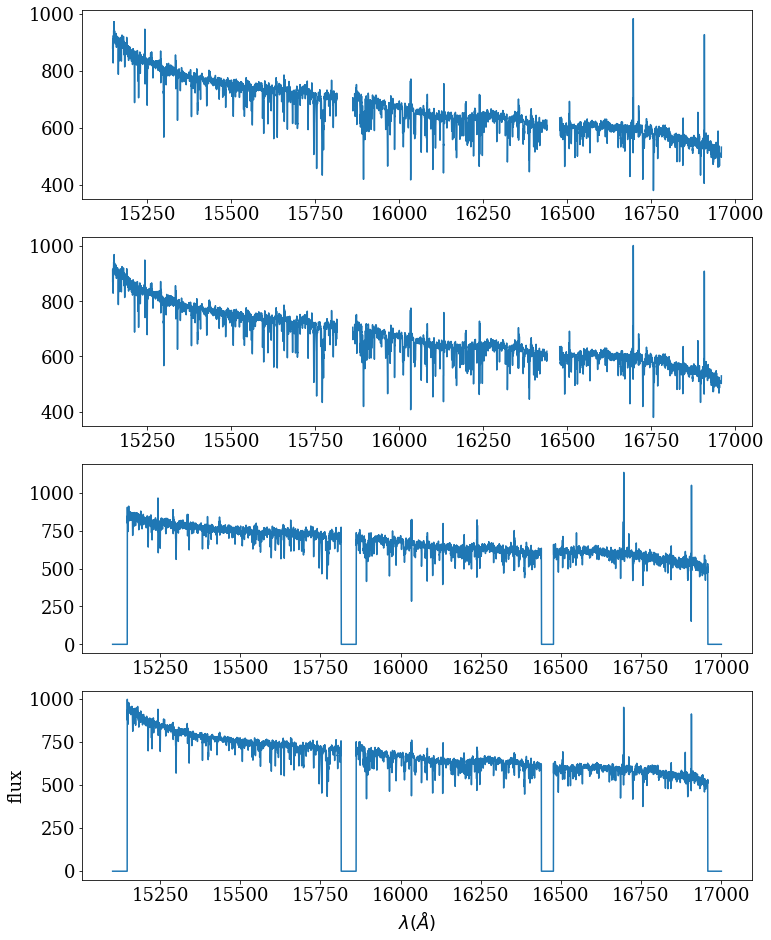

In [139]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(12,16))

ax0.plot(w, f[0,:]) # combined spectrum with pixel-based weighting
ax1.plot(w, f[1,:]) # combined spectrum with global weighting
ax2.plot(w, f[2,:]) # individual spectrum at NVISIT = 1
ax3.plot(w, f[3,:]) # individual spectrum at NVISIT = 2

plt.xlabel('$\lambda (\AA)$')
plt.ylabel('flux')

In [47]:
f.shape # 4 flux arrays, but same wavelength solution, different from APF data where there are 15 orders with different wavelength solution --> plot each of them to compare, different methods of extraction lead to different flux arrays

(4, 8575)

In [48]:
w.shape
# nf=len(f[0,:]) # : means getting all the data in that dimension
# w=np.empty(nf) # so w has the right dimension

(8575,)

# Resources:
- https://www.sdss.org/dr17/irspec/apogee-bitmasks/
- https://docs.astropy.org/en/stable/io/fits/index.html
    - Each element of an HDUList is an HDU object with `.header` and `.data` attributes, which can be used to access the header and data portions of the HDU.
- https://docs.astropy.org/en/stable/io/fits/api/hdus.html
- https://www.sdss.org/dr12/irspec/parameters/
- https://github.com/sdss/apogee2_tutorials/blob/main/examples/APOGEE_Keil_Diagram.ipynb
- https://github.com/sdss/apogee2_tutorials/blob/main/examples/APOGEE_Abundance_Plot.ipynb
- In computer science, a mask or bitmask is data that is used for bitwise operations, particularly in a bit field. Using a mask, multiple bits in a byte, nibble, word, etc. can be set either on or off, or inverted from on to off in a single bitwise operation. An additional use of masking involves predication in vector processing, where the bitmask is used to select which element operations in the vector are to be executed and which are not.
- https://docs.astropy.org/en/stable/io/fits/api/files.html#astropy.io.fits.getdata
- https://pyfits.readthedocs.io/en/3.0-stable/users_guide/users_tutorial.html
- https://second.wiki/wiki/g-band-magnitude
- `FITS_rec` is the data part of a table HDU’s data part. This is a layer over the `recarray`, so we can deal with scaled columns. It inherits all of the standard methods from `numpy.ndarray`.
- https://www.eso.org/~ohainaut/ccd/sn.html